# 10_qc_bucket_eval_segmentation.ipynb

This notebook evaluates **UNet segmentation robustness by QC bucket**:

1. Compute QC score for every image (clean + degraded).
2. Assign QC bucket: `Excellent` vs `Poor`.
3. Evaluate **baseline** and **robust** UNet models on:
   - Clean validation (AqUavplant/val) split by QC bucket
   - Each corruption × severity split by QC bucket

Outputs:
- `processed/qc/qc_labels.parquet`
- `runs/seg_eval_qc_clean.csv`
- `runs/seg_eval_qc_by_severity.csv`


In [ ]:
!pip install segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
print("Mounting Google Drive...")
drive.mount('/content/drive', force_remount=True)

from pathlib import Path
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import jaccard_score, f1_score
import segmentation_models_pytorch as smp

# Paths
ROOT = Path("/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data")
CSV_PATH = ROOT/"processed/metadata.csv"
DEGRAD_MANIFEST = ROOT/"processed/degraded_sets"/"degraded_manifest.parquet"
QC_DIR = ROOT/"processed/qc"
QC_DIR.mkdir(parents=True, exist_ok=True)
QC_LABELS_PATH = QC_DIR/"qc_labels.parquet"

RUNS_DIR = ROOT/"runs"
RUNS_DIR.mkdir(exist_ok=True)

# Load weights
ROBUST_W = RUNS_DIR/"unet_resnet34_aquavplant_robust.pt"
BASE_CANDS = sorted([p for p in RUNS_DIR.glob("unet_resnet34*.pt") if "robust" not in p.name])
BASELINE_W = BASE_CANDS[0] if BASE_CANDS else None

print("Baseline:", BASELINE_W)
print("Robust:", ROBUST_W)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# QC bucket threshold
QC_EXCELLENT_MIN = 0.6


Mounting Google Drive...
Mounted at /content/drive
Baseline: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant.pt
Robust: /content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs/unet_resnet34_aquavplant_robust.pt
Using device: cuda


In [ ]:
# --- QC functions (your app logic) ---
import numpy as np
from PIL import Image

def _laplacian_var(gray: np.ndarray) -> float:
    k = np.array([[0,1,0],[1,-4,1],[0,1,0]], dtype=np.int32)
    H, W = gray.shape
    if H < 3 or W < 3:
        return 0
    pad = np.pad(gray.astype(np.int32), 1)
    out = (
        k[0,0]*pad[0:H,0:W] + k[0,1]*pad[0:H,1:W+1] + k[0,2]*pad[0:H,2:W+2] +
        k[1,0]*pad[1:H+1,0:W] + k[1,1]*pad[1:H+1,1:W+1] + k[1,2]*pad[1:H+1,2:W+2] +
        k[2,0]*pad[2:H+2,0:W] + k[2,1]*pad[2:H+2,1:W+1] + k[2,2]*pad[2:H+2,2:W+2]
    )
    return float(out.var())

def compute_qc(image_path: str) -> dict:
    with Image.open(image_path) as im:
        arr = np.array(im.convert("L"), dtype=np.uint8)
    brightness = float(arr.mean())
    blur_var = _laplacian_var(arr)
    blur_score = max(0, min(1, (blur_var - 20) / (200 - 20)))
    bright_score = max(0, min(1, (brightness - 50) / (200 - 50)))
    score = round(0.6*blur_score + 0.4*bright_score, 3)
    return {"image_path": image_path, "brightness": brightness,
            "blur_var": blur_var, "score": score}


In [ ]:
df = pd.read_csv(CSV_PATH)

# Only segmentation data
val_seg = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)
print("Clean seg val:", len(val_seg))

df_deg = pd.read_parquet(DEGRAD_MANIFEST)
df_deg_seg = df_deg.query("split=='val' and source=='aquavplant'").reset_index(drop=True)
df_deg_seg["severity"] = df_deg_seg["severity"].astype(int)

print("Degraded seg rows:", len(df_deg_seg))
print("Corruptions:", df_deg_seg["corruption"].unique())
print("Severities:", df_deg_seg["severity"].unique())


Clean seg val: 27
Degraded seg rows: 405
Corruptions: ['jpeg' 'lowres' 'defocus' 'brightness' 'noise']
Severities: [1 2 3]


In [ ]:
if QC_LABELS_PATH.exists():
    qc_df = pd.read_parquet(QC_LABELS_PATH)
    print("Loaded QC labels:", len(qc_df))
else:
    paths = sorted(set(val_seg["image_path"]).union(df_deg_seg["image_path"]))
    rows = []
    for p in tqdm(paths, desc="QC scoring"):
        rows.append(compute_qc(p))
    qc_df = pd.DataFrame(rows)

    qc_df["qc_bucket"] = qc_df["score"].apply(lambda s: "Excellent" if s >= QC_EXCELLENT_MIN else "Poor")
    qc_df.to_parquet(QC_LABELS_PATH, index=False)

qc_df.head()


QC scoring:   0%|          | 0/432 [00:00<?, ?it/s]

,image_path,brightness,blur_var,score,qc_bucket
0,/content/drive/MyDrive/HyacinthWatch_workspace...,146.268459,526.644525,0.857,Excellent
1,/content/drive/MyDrive/HyacinthWatch_workspace...,143.680492,365.863899,0.850,Excellent
2,/content/drive/MyDrive/HyacinthWatch_workspace...,141.669907,514.775814,0.844,Excellent
3,/content/drive/MyDrive/HyacinthWatch_workspace...,123.251560,1361.885187,0.795,Excellent
4,/content/drive/MyDrive/HyacinthWatch_workspace...,123.957851,1579.180324,0.797,Excellent


In [ ]:
# Dataset
SIZE_SEG = 512
tfm_eval_seg = A.Compose([
    A.LongestMaxSize(max_size=SIZE_SEG),
    A.PadIfNeeded(min_height=SIZE_SEG,min_width=SIZE_SEG,border_mode=0,value=(128,128,128),mask_value=0),
    A.Normalize(mean=(0.485,0.456,0.406),std=(0.229,0.224,0.225)),
    ToTensorV2()
])

class SegDS(Dataset):
    def __init__(self, df):
        self.df = df.reset_index(drop=True)
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = np.array(Image.open(row.image_path).convert("RGB"))
        mask = (np.array(Image.open(row.mask_path).convert("L"))>127).astype(np.float32)
        out = tfm_eval_seg(image=img, mask=mask)
        return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path

def loader(df, bs=16):
    return DataLoader(SegDS(df), batch_size=bs, shuffle=False, num_workers=0)

# Model + metrics
def make_unet():
    return smp.Unet("resnet34", encoder_weights=None,in_channels=3,classes=1).to(device)

def load_model(path):
    m = make_unet()
    m.load_state_dict(torch.load(path,map_location=device))
    m.eval()
    return m

@torch.no_grad()
def eval_seg(model, dl):
    preds, trues = [], []
    for xb, yb, _ in dl:
        xb = xb.to(device)
        p = torch.sigmoid(model(xb)).cpu().numpy()
        preds.append(p)
        trues.append(yb.cpu().numpy())
    P = np.concatenate(preds)
    T = np.concatenate(trues)
    Pbin = (P>0.5).astype(int)
    Tbin = (T>0.5).astype(int)
    iou = jaccard_score(Tbin.flatten(),Pbin.flatten(),average='binary')
    dice = f1_score(Tbin.flatten(),Pbin.flatten(),average='binary')
    cover_err = np.abs(Pbin.mean(axis=(1,2,3)) - Tbin.mean(axis=(1,2,3))).mean()
    return iou, dice, cover_err


/tmp/ipython-input-2930669183.py:5: UserWarning: Argument(s) 'value, mask_value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=SIZE_SEG,min_width=SIZE_SEG,border_mode=0,value=(128,128,128),mask_value=0),


In [ ]:
clean_qc = val_seg.merge(qc_df[["image_path","qc_bucket","score"]], on="image_path", how="left")

rows = []
for name, wpath in [("baseline", BASELINE_W), ("robust", ROBUST_W)]:
    if wpath is None or not wpath.exists():
        continue
    model = load_model(wpath)
    for bucket in ["Excellent", "Poor"]:
        sub = clean_qc[clean_qc["qc_bucket"]==bucket]
        if len(sub)==0: continue
        iou,dice,err = eval_seg(model, loader(sub))
        rows.append(dict(model=name, qc_bucket=bucket,
                         corruption="clean", severity=0,
                         iou=iou, dice=dice, cover_abs_err=err, n=len(sub)))

seg_clean_qc = pd.DataFrame(rows)
seg_clean_qc.to_csv(RUNS_DIR/"seg_eval_qc_clean.csv", index=False)
seg_clean_qc


/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path
/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path


,model,qc_bucket,corruption,severity,iou,dice,cover_abs_err,n
0,baseline,Excellent,clean,0,0.666125,0.799610,0.031721,27
1,robust,Excellent,clean,0,0.662071,0.796682,0.021826,27


In [ ]:
deg_qc = df_deg_seg.merge(qc_df[["image_path","qc_bucket","score"]], on="image_path", how="left")

rows = []
for name, wpath in [("baseline", BASELINE_W), ("robust", ROBUST_W)]:
    if wpath is None or not wpath.exists():
        continue
    model = load_model(wpath)
    for corr in sorted(deg_qc["corruption"].unique()):
        for sev in sorted(deg_qc["severity"].unique()):
            for bucket in ["Excellent","Poor"]:
                sub = deg_qc.query("corruption==@corr and severity==@sev and qc_bucket==@bucket")
                if len(sub)==0: continue
                iou,dice,err = eval_seg(model, loader(sub))
                rows.append(dict(model=name, qc_bucket=bucket,
                                 corruption=corr, severity=int(sev),
                                 iou=iou, dice=dice, cover_abs_err=err,
                                 n=len(sub)))

seg_qc_bysev = pd.DataFrame(rows)
seg_qc_bysev.to_csv(RUNS_DIR/"seg_eval_qc_by_severity.csv", index=False)
seg_qc_bysev.head()


/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path
/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path
/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return out["image"], torch.tensor(out["mask"]).unsqueeze(0), row.image_path
/tmp/ipython-input-2930669183.py:19: UserWarning: To copy construct

,model,qc_bucket,corruption,severity,iou,dice,cover_abs_err,n
0,baseline,Excellent,brightness,1,0.668382,0.801234,0.029885,26
1,baseline,Poor,brightness,1,0.437284,0.608486,0.001720,1
2,baseline,Excellent,brightness,2,0.641412,0.781537,0.035344,26
3,baseline,Poor,brightness,2,0.177820,0.301947,0.006916,1
4,baseline,Excellent,brightness,3,0.601819,0.751419,0.034101,26


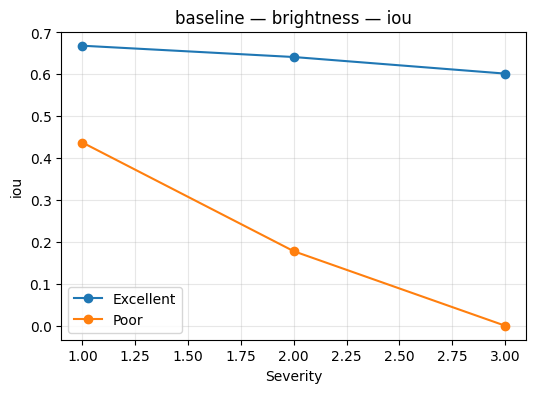

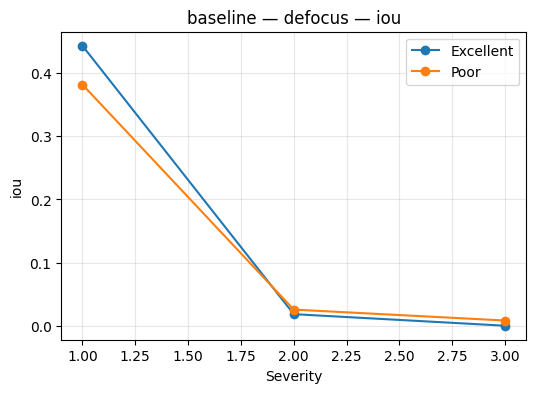

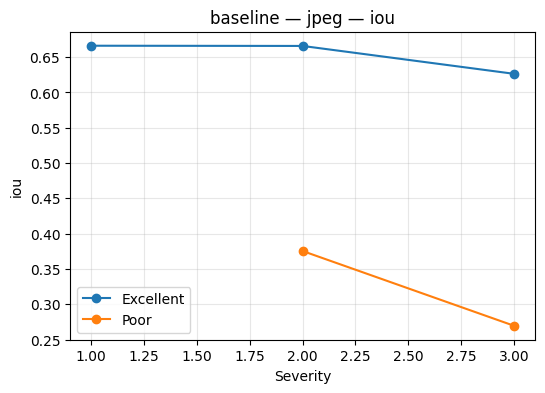

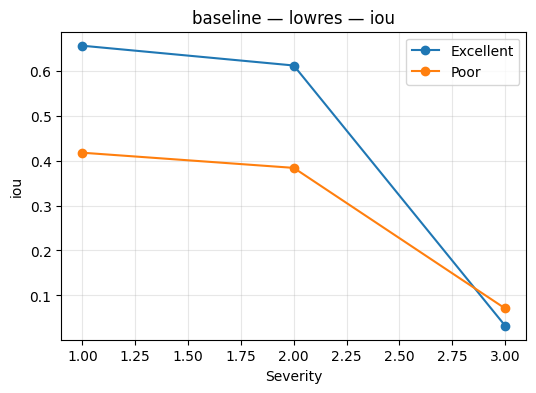

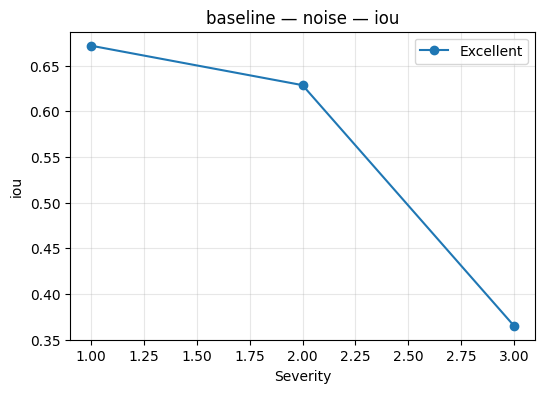

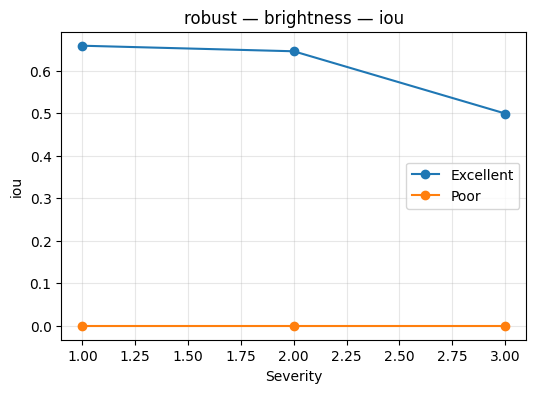

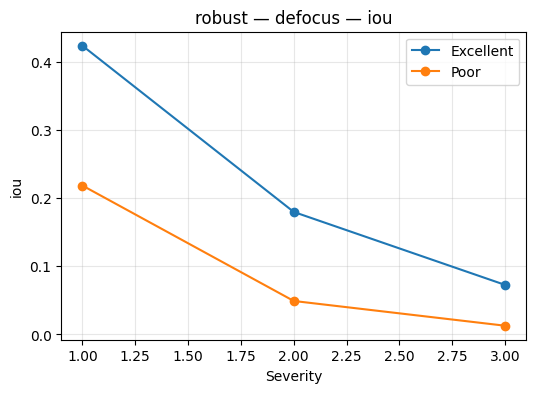

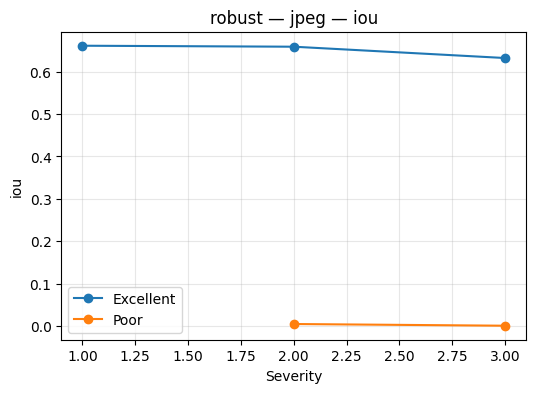

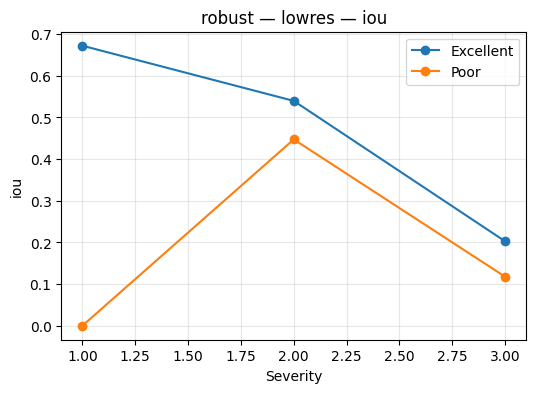

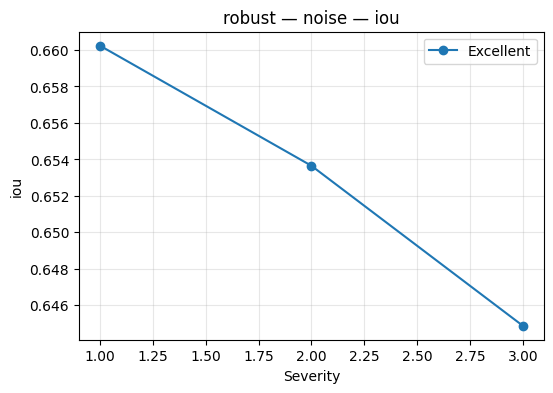

In [ ]:
def plot_qc(df, model, metric="iou"):
    for corr in sorted(df["corruption"].unique()):
        sub = df[(df["model"]==model)&(df["corruption"]==corr)]
        if sub.empty: continue
        plt.figure(figsize=(6,4))
        for bucket in ["Excellent","Poor"]:
            sb = sub[sub["qc_bucket"]==bucket]
            if sb.empty: continue
            plt.plot(sb["severity"], sb[metric], marker="o", label=bucket)
        plt.title(f"{model} — {corr} — {metric}")
        plt.xlabel("Severity"); plt.ylabel(metric)
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

for model in ["baseline","robust"]:
    if model in seg_qc_bysev["model"].unique():
        plot_qc(seg_qc_bysev, model, metric="iou")
